# 2 项目演示
本章将进行一个完整的项目演示，以便加深对建模流程的理解。
## 2.1 项目背景
实际项目中，在开展建模工作前，以下信息是必须确认的：
- 建模目标：**商业目标**乃唯一目标，因为建模本身是为了解决实际业务问题。
- 预期收益：预期达到的业务效果或评价标准，如存在现有解决方案，也可统计相关数据以备比较。
- 应用方案：未来模型在业务中的部署和使用方案。

以上信息决定了项目数据的来源、机器学习的类别，优先选择的算法及后续维护成本，模型的评价标准及其精度等。

任务开始：
```
假设你是一名汽车预测油耗

一个用来预测70年代末到80年代初汽车燃油效率的模型。数据集提供了汽车相关描述，包含：气缸数，排量，马力以及重量等（这些统称为属性）。
'mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name'

属性信息：
1.英里/加仑:连续值
2.气缸:离散值
3.位移:连续值
4.马力:连续值
5.重量:连续值
6.加速度:连续值
7.模型年份:离散值
8.产地:离散值
9.汽车品牌:字符串
```
## 2.2 数据处理
### 2.2.1 获取数据
数据来源于UCI的开源数据[Auto MPG](https://archive.ics.uci.edu/ml/datasets/Auto+MPG)。


In [1]:
import pandas as pd
auto_mpg = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data',header=None,sep='\s+',na_values=['?'])
auto_mpg.columns = ['mpg','cylinders','displacement','horsepower','weight','acceleration','model_year','origin','car_name']
auto_mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,car_name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


### 2.2.2 划分数据
将数据处理聚焦于训练集，避免影响评估模型效果的客观性，实际应用中，确定模型后可用全量数据集微调最终模型。

In [2]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(auto_mpg,auto_mpg.mpg,test_size=0.2,random_state=11)
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
mpg,318.0,23.338365,7.782142,9.0,17.000,22.0,28.95,44.6
cylinders,318.0,5.468553,1.702833,3.0,4.000,4.0,8.00,8.0
displacement,318.0,194.316038,105.492887,68.0,104.250,146.0,261.50,455.0
horsepower,313.0,105.361022,39.379327,46.0,75.000,95.0,130.00,230.0
weight,318.0,2972.610063,848.562584,1613.0,2226.500,2831.5,3556.00,4997.0
acceleration,318.0,15.522956,2.832508,8.0,13.625,15.5,17.00,24.8
model_year,318.0,75.858491,3.697826,70.0,73.000,76.0,79.00,82.0
origin,318.0,1.584906,0.804576,1.0,1.000,1.0,2.00,3.0


In [3]:
x_train.car_name.value_counts()/x_train.shape[0]

ford pinto                      0.012579
toyota corolla                  0.012579
ford maverick                   0.012579
chevrolet impala                0.012579
pontiac catalina                0.009434
                                  ...   
chrysler new yorker brougham    0.003145
datsun 310                      0.003145
ford fairmont (auto)            0.003145
volkswagen rabbit               0.003145
vw dasher (diesel)              0.003145
Name: car_name, Length: 256, dtype: float64

### 2.2.3 数据预处理
从数据的描述信息中本身数据集不大，```horsepower```字段存在缺失；```origin```、```cylinders```字段单一值集中度较高；```car_name```作为字符串分布又很分散；各特征刻度分布较分散。针对上述问题，我们将着手开始进行数据的预处理，其中由于```car_name```过于分散本项目中舍弃了其使用（关于字符型数据的处理后续会讨论）。

**可视化：**

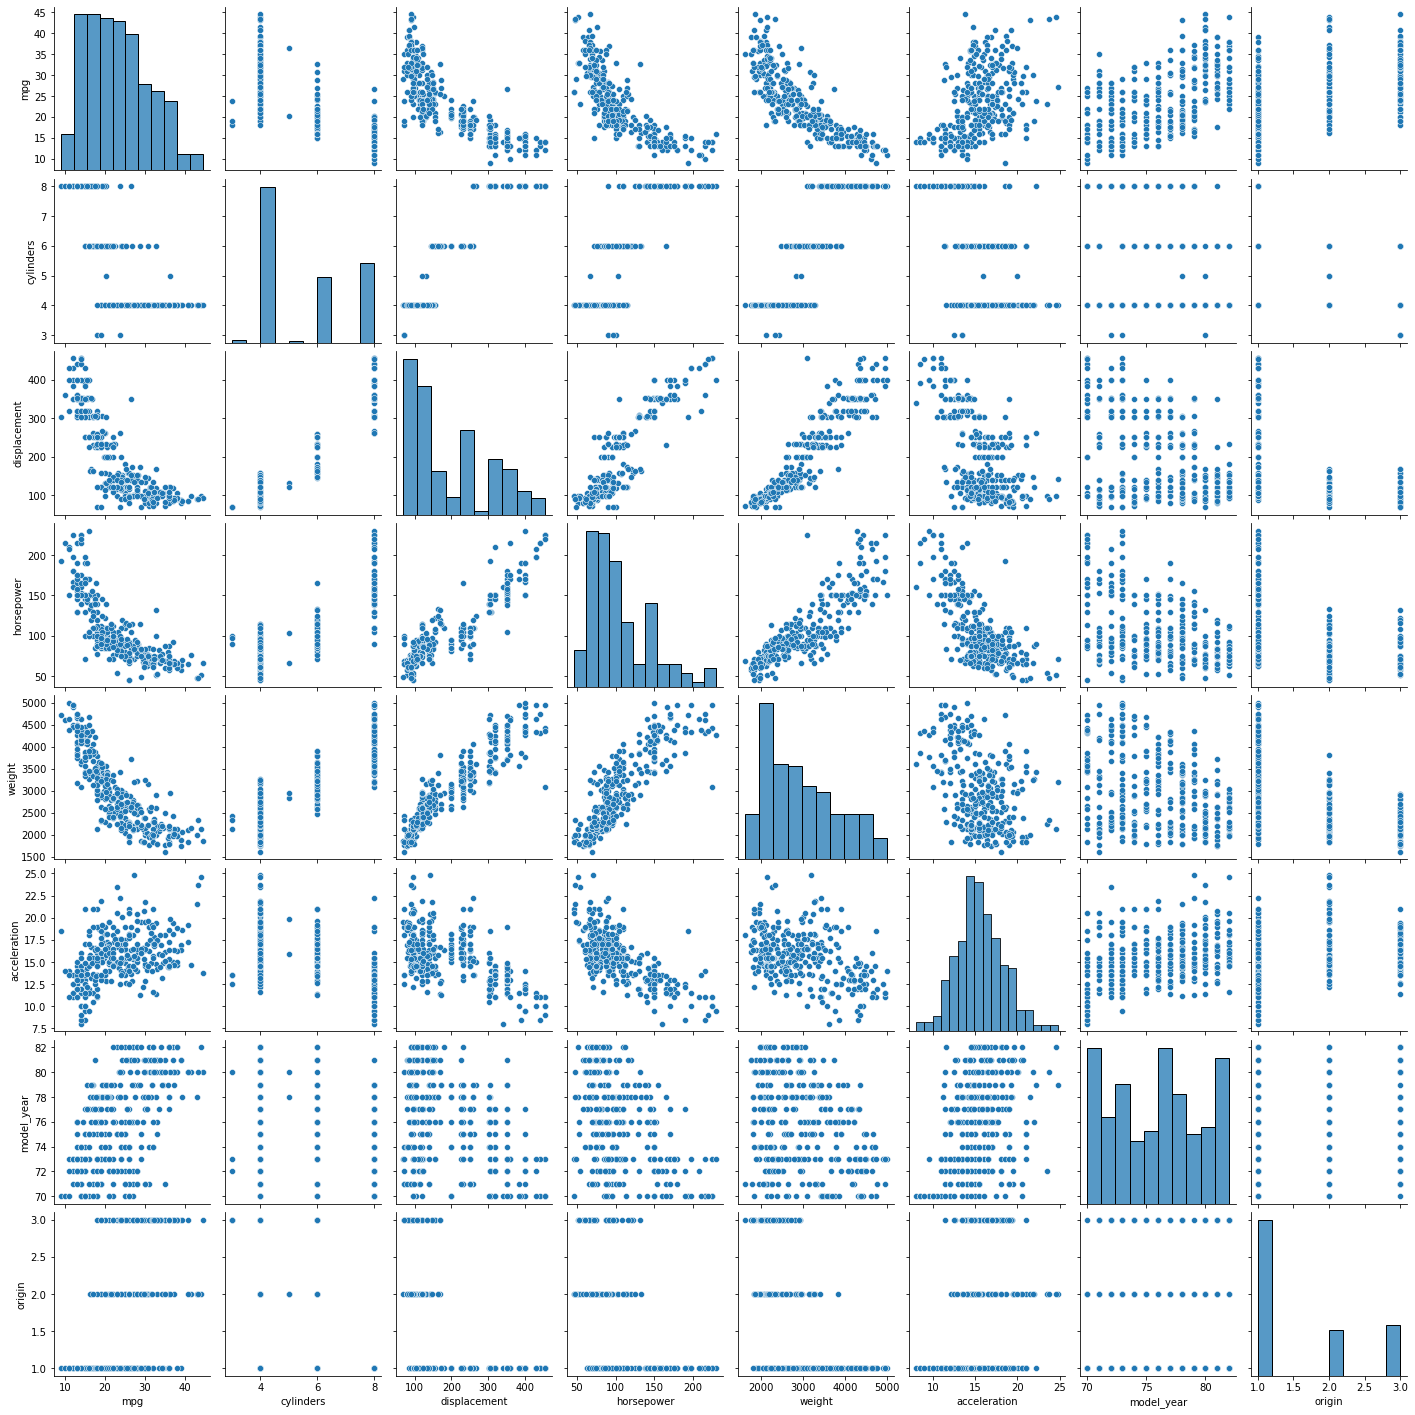

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.pairplot(x_train)

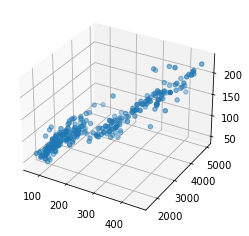

In [5]:
fig = plt.figure()
ax = plt.gca(projection='3d')
ax.scatter3D(x_train.displacement,x_train.weight,x_train.horsepower, cmap='Blues')

**缺失处理：**

目标变量```mpg```与```displacement```,```horsepower```,```weigh```三个特征存在一定的联系，三个特征又有着一定的线性关联,所以使用knn对缺失进行填充。

In [6]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
def knn_missing_filled(train,test,col,target,k=3,dispersed=True):
    if dispersed:
        clf = KNeighborsClassifier(n_neighbors=k, weights="distance")
    else:
        clf = KNeighborsRegressor(n_neighbors=k, weights="distance")
    x = train[train[target].notnull()][col]
    y = train[train[target].notnull()][target]
    clf.fit(x, y)
    train_impute = train[train[target].isnull()]
    test_impute = test[test[target].isnull()]
    train[target][train_impute.index] = clf.predict(train_impute[col])
    test[target][test_impute.index] = clf.predict(test_impute[col])
    return train,test

x_train,x_test = knn_missing_filled(x_train,x_test,col=['displacement','weight'],target='horsepower')

**归一化：**

除了origin代表的地区编码外，其余的都可以进行归一化，统一刻度尺，以便模型系数权重的等效性，这在梯度下降的时候将会显得很重要。

In [8]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
x_train = x_train[['cylinders','displacement','horsepower','weight','acceleration','model_year','origin']]
x_test = x_test[['cylinders','displacement','horsepower','weight','acceleration','model_year','origin']]
col = ['cylinders','displacement','horsepower','weight','acceleration','model_year']
ss.fit(x_train[col])
x_train[col] = ss.transform(x_train[col])
x_test[col] = ss.transform(x_test[col])

## 2.3 模型设计
由于特征与目标变量大多呈现非线性关系，数据集本身也不大，准备选用svm模型建模，并依据效果微调模型。


In [17]:
from sklearn.svm import SVR
clf = SVR(kernel='rbf')
clf.fit(x_train,y_train)

SVR()

## 2.4 模型评估

In [21]:
from sklearn.metrics import mean_squared_error
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
print('train_mse:%s,\ntest_mse:%s.' % (round(mean_squared_error(y_train,y_train_pred),2),round(mean_squared_error(y_test,y_test_pred),2)))

train_mse:8.49,
test_mse:11.3.


<AxesSubplot:xlabel='mpg'>

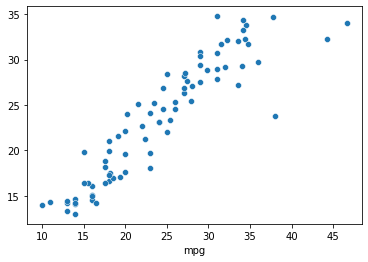

In [16]:
sns.scatterplot(y_test,y_test_pred)

## 2.5 应用模型
**保存&部署：**

In [20]:
from sklearn.externals import joblib
joblib.dump(clf, 'svr.joblib') 

['svr.joblib']

很好，你被允许启动系统了！你需要为实际生产做好准备，特别是接入输入数据源，并编写测试。

**监控&维护：**

你还需要编写监控代码，以固定间隔检测系统的实时表现，当发生下降时触发报警。这对于捕获突然的系统崩溃和性能下降十分重要。做监控很常见，是因为模型会随着数据的演化而性能下降，除非模型用新数据定期训练。

以上只是个简单的任务，体验下整个流程，模型很粗糙，效果也一般，我们下面开始深入的学习吧。